---
---
---
# **Fake News Classification**
## Max Mager, Teo Förste, Vladislav Antonov | Prof. Dr. Grüttmüller | Mustererkennung SS25
---
---
---
![Alt-Text](./Bilder/Intro.png)
<small> Bild erstellt mit DALL-E </small>
---
---
---

## **Motivation**
---
---
---

# Trump says to stop visa abuses that undermine U.S. workers,"BATON ROUGE, La - U.S. President-elect Donald Trump on Friday pledged to stop companies from abusing the visa process for foreign workers in a way that undermines the labor market for Americans. Speaking at a rally in Baton Rouge, Louisiana, Trump said he had spent time during the presidential campaign with workers who were laid off but forced to train foreign hires brought in to replace them. “That’s actually demeaning,” Trump said. “We’re not going to let that happen any more.” Without naming companies, he said firms would withhold severance pay from the workers unless they trained their foreign replacements.     “One of my first executive orders will be to ask the Department of Labor to investigate all visa abuses that undermine jobs and wages to the American worker,” he said.


# Fake? Real? Unsicher?

---
---
---

<h1 style="font-size: 32px;">Inhaltsverzeichnis</h1>

<ol style="font-size: 20px;">
  <li>Primäre Datasets</li>
  <li>Vergleich von One-Class-Methoden</li>
  <li>Hyperparameter Tuning</li>
  <li>NLP mit SpaCy, Training mit BERT (DistilBERT)</li>
  <li>Multiple logistische Regression</li>
  <li>Random Forest</li>
  <li>Auswertung mit neuen Datensätzen und allgemeinen Modell</li>
</ol>


---
---
---
## **Datasets von *Huggingface* und *Kaggle***
---
---
---

In [8]:
import pandas as pd

# Deine Tabelle als DataFrame
data = {
    "Eigenschaften\\Dataset": ["Ersteller*in", "Veröffentlicht", "Einträge gerundet ~", "Zusammenstellung", "Quelle"],
    "Fake News Classification": ["Saurabh Shahane", "2021", "72000", "Reuters, Kaggle, McIntire, Buzzfeed", "[1]"],
    "fake_news": ["Gonzalo Álvarez", "2021", "41000", "Kaggle, Reuters", "[2]"],
    "fake-news-detection-dataset-English": ["Erfan Moosavi Monazzah", "2023", "44000", "Kaggle", "[3]"],
    "Fake News Detection": ["Bhavik Jikadara", "2024", "45000", "Unbekannt", "[4]"]
}

df = pd.DataFrame(data)

# Tabelle mit größerer Schrift anzeigen
def style_table(df):
    return df.style.set_table_styles(
        [{
            'selector': 'th',
            'props': [('font-size', '14pt'), ('text-align', 'center')]
        }, {
            'selector': 'td',
            'props': [('font-size', '12pt'), ('padding', '10px')]
        }]
    ).set_properties(**{'text-align': 'center'})

style_table(df)


,Eigenschaften\Dataset,Fake News Classification,fake_news,fake-news-detection-dataset-English,Fake News Detection
0,Ersteller*in,Saurabh Shahane,Gonzalo Álvarez,Erfan Moosavi Monazzah,Bhavik Jikadara
1,Veröffentlicht,2021,2021,2023,2024
2,Einträge gerundet ~,72000,41000,44000,45000
3,Zusammenstellung,"Reuters, Kaggle, McIntire, Buzzfeed","Kaggle, Reuters",Kaggle,Unbekannt
4,Quelle,[1],[2],[3],[4]


<small>
- [1] Fake news classification (2023): Kaggle, [online] https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification [abgerufen am 06.06.2025]
- [2] GonzaloA/fake_news · Datasets at Hugging Face (2024): [online] https://huggingface.co/datasets/GonzaloA/fake_news [abgerufen am 06.06.2025]
- [3] ErfanMoosaviMonazzah/fake-news-detection-dataset-English · Datasets at Hugging Face (2024): [online] https://huggingface.co/datasets/ErfanMoosaviMonazzah/fake-news-detection-dataset-English [abgerufen am 06.06.2025]
- [4] Fake news detection (2023): Kaggle, [online] https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection [abgerufen am 08.06.2025]
</small>

In [10]:
#pip install "numpy<2.0" #uncomment on incompatiblity problems with numpy version

In [11]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

base_path = '../src/data'
datasets = {}

def read_titles(filepath, dataset_name):
    # Sonderbehandlung für den Datensatz "Saurabh Shahane - Fake_News_Classification"
    if dataset_name.lower() == 'saurabh shahane':
        try:
            df = pd.read_csv(filepath, sep=',', usecols=['title'], dtype=str)
            return df['title'].dropna().astype(str).str.strip().str.lower().tolist()
        except Exception:
            return []

    # Standardverarbeitung
    for sep in [',', ';', '\t']:
        try:
            df = pd.read_csv(filepath, sep=sep, engine='python', usecols=['title'], dtype=str)
            return df['title'].dropna().astype(str).str.strip().str.lower().tolist()
        except Exception:
            continue
    return []

# Lade alle Datasets ein
folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    all_titles = []
    files = glob.glob(os.path.join(folder_path, '*'))

    for filepath in files:
        titles = read_titles(filepath, folder)
        all_titles.extend(titles)

    unique_titles = set(all_titles)
    datasets[folder] = unique_titles

# Berechne Übereinstimmungsmatrix
result = pd.DataFrame(index=datasets.keys(), columns=datasets.keys(), dtype=float)
dataset_names = list(datasets.keys())

for i, a in enumerate(dataset_names):
    for b in dataset_names[i+1:]:
        titles_a = datasets[a]
        titles_b = datasets[b]

        if len(titles_a) == 0:
            score_ab = 0.0
        else:
            inter_ab = len(titles_a.intersection(titles_b))
            score_ab = (inter_ab / len(titles_a)) * 100

        if len(titles_b) == 0:
            score_ba = 0.0
        else:
            inter_ba = len(titles_b.intersection(titles_a))
            score_ba = (inter_ba / len(titles_b)) * 100

        result.loc[a, b] = score_ab
        result.loc[b, a] = score_ba

for name in dataset_names:
    result.loc[name, name] = 100.0

result = result.round(2)


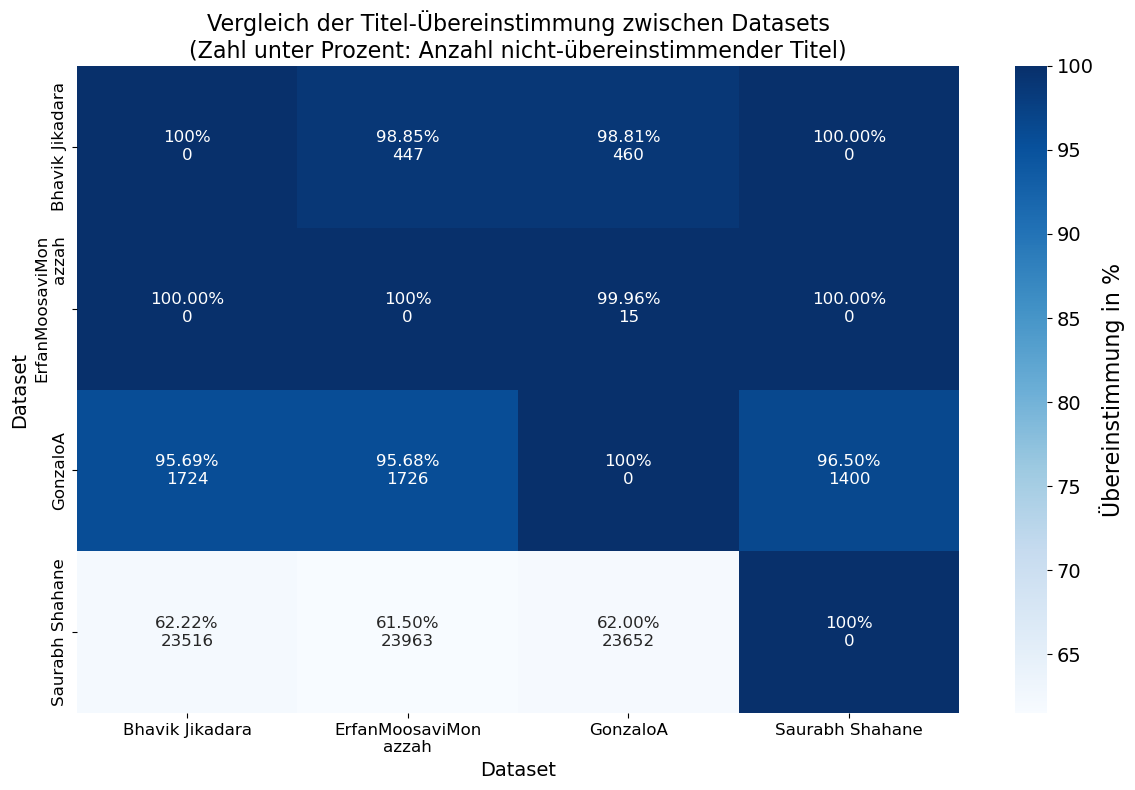

In [12]:
import textwrap

max_label_length = max(len(name) for name in dataset_names)
wrap_width = 15 if max_label_length > 15 else max_label_length

annot = result.copy().astype(str)
for i, a in enumerate(dataset_names):
    for j, b in enumerate(dataset_names):
        if a == b:
            annot.loc[a, b] = "100%\n0"
        else:
            titles_a = datasets[a]
            titles_b = datasets[b]
            unmatched_count = len(titles_a - titles_b)
            percent = result.loc[a, b]
            annot.loc[a, b] = f"{percent:.2f}%\n{unmatched_count}"

plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    result,
    annot=annot.values,
    fmt="",
    cmap='Blues',
    cbar_kws={'label': 'Übereinstimmung in %'},
    annot_kws={"fontsize": 12}
)

# Colorbar-Schriftgröße anpassen
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_size(16)   # Größe für Label an der Colorbar (Übereinstimmung in %)
cbar.ax.tick_params(labelsize=14)  # Größe für die Zahlen an der Colorbar

wrapped_xticklabels = [textwrap.fill(name, width=wrap_width) for name in dataset_names]
wrapped_yticklabels = [textwrap.fill(name, width=wrap_width) for name in dataset_names]

ax.set_xticklabels(wrapped_xticklabels, fontsize=12, rotation=0, ha='center')
ax.set_yticklabels(wrapped_yticklabels, fontsize=12, va='center')

plt.title('Vergleich der Titel-Übereinstimmung zwischen Datasets\n(Zahl unter Prozent: Anzahl nicht-übereinstimmender Titel)', fontsize=16)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Dataset', fontsize=14)

plt.tight_layout()
plt.show()


---
---
---

# Multiple Logistische Regression
___

- Anwendung auf nominalskalierte Kriterien
  - in unserem Fall binär logistisch --> Real = 0 oder Fake = 1 (oder andersherum)
- mehrere Prädiktoren bestehend aus Verknüpfung von Titel + Text
- sagt aus wie wahrscheinlich Real oder Fake
- Feature-Dimension wird durch TfidfVectorizer erstellt

Die allgemeine Formel der multiplen logistischen Regression lautet:

$$
P(Y = 1 \mid \mathbf{x}) = \frac{1}{1 + e^{-\mathbf{x}^\top \boldsymbol{\beta}}}
$$

- **$\mathbf{x} = (x_1, x_2, \dots, x_n)$**  
  Merkmalsvektor eines Artikels, erstellt mit `TfidfVectorizer`.  
  Jeder Eintrag $x_i$ ist der TF-IDF-Wert eines bestimmten Wortes aus Titel und Text.

- **$\boldsymbol{\beta} = (\beta_0, \beta_1, \dots, \beta_n)$**  
  Regressionskoeffizienten des Modells.  
  $\beta_i$ gibt an, wie stark das Merkmal $x_i$ (ein Wort) zur Vorhersage "Fake News" beiträgt.

- **$\beta_0$**  
  Bias-Term (Grundwahrscheinlichkeit ohne Einfluss der Merkmale).

> **Beispiel:**  
> Wenn "clickbait" im Artikel nicht vorkommt ($x_1 = 0$) und "vaccine" häufig ($x_2 = 0{,}15$), dann fließen diese Werte gewichtet durch $\beta_1$, $\beta_2$ in die Entscheidung ein.

**Ziel:**  
Schätzung der Wahrscheinlichkeit, dass ein Artikel Fake News ist





<small>Multiple regression (o. D.): [Studyflix] https://studyflix.de/statistik/multiple-regression-2149 [abgerufen am 09.06.2025].</small>

___
# Term Frequency-Inverse Document Frequency (TF-IDF) Vektorisierer
___

## Verfahren zur Gewichtung von Wörtern in Texten  

**TF-IDF** bewertet, wie wichtig ein Wort für ein bestimmtes Dokument ist im Vergleich zu allen anderen Dokumenten

---

### TF (Term Frequency)

**Formel:**

$TF(t, d) = \frac{\text{Anzahl von } t \text{ in } d}{\text{Gesamtanzahl Wörter in } d}$

- `t`: Wort (Term)  
- `d`: Dokument (Text)  
- **Ziel:** Häufige Begriffe _innerhalb eines Dokuments_ hervorheben.

**Beispiel:**

Dokument: `"Ich mag Kuchen und ich mag Kaffee"`  
- Wort „mag“ kommt 2-mal vor  
- Insgesamt 7 Wörter  
- $TF(\text{"mag"}, d) = \frac{2}{7} \approx 0{,}286$

---

### IDF (Inverse Document Frequency)

**Formel:**

$$
IDF(t) = \log\left(\frac{N + 1}{df(t) + 1}\right) + 1
$$

- `N`: Gesamtanzahl Dokumente  
- `df(t)`: Anzahl der Dokumente, die den Begriff `t` enthalten  
- **Ziel:** Häufige Begriffe im _gesamten Korpus abwerten_ (z. B. „the“, „and“).

**Beispiel:**

Dataset mit 3 Dokumenten:  
1. „Ich liebe Kaffee“  
2. „Ich liebe Kuchen“  
3. „Kaffee ist heiß“

- Das Wort „Kaffee“ kommt in 2 von 3 Dokumenten vor → $df("Kaffee") = 2$  
- $N = 3$

$$
IDF("Kaffee") = \log\left(\frac{4}{3}\right) + 1 \approx 1{,}124
$$

---

### TF-IDF

**Formel:**

$$
TF\text{-}IDF(t, d) = TF(t, d) \cdot IDF(t)
$$

**Beispiel:**

Wenn:  
- $TF("Kaffee", d) = 0{,}2$  
- $IDF("Kaffee") = 1{,}124$

Dann:  
$$
TF\text{-}IDF("Kaffee", d) = 0{,}2 \cdot 1{,}124 = 0{,}2526
$$

---

### TF-IDF Vektorisierer

- Wandelt Text in numerische Vektoren um
- Jedes Dokument wird zu einem Vektor, dessen Einträge die TF-IDF-Werte der Wörter sind


<small>Anurag (2024): TF-IDF Vectorizer explained - Anurag - medium, in: Medium, 27.11.2024, [online] https://medium.com/@gusainanurag58/tf-idf-vectorizer-explained-373b3f07d23b.</small>

___
# Multiple Logistische Regression angewandt auf Welfake
___

In [22]:
import pandas as pd  # Importiert die Pandas-Bibliothek zur Datenverarbeitung und -analyse
import numpy as np  # Importiert NumPy für numerische Operationen, z. B. mit Arrays

# Für das Aufteilen des Datensatzes in Trainings-, Validierungs- und Testdaten
from sklearn.model_selection import train_test_split

# Für die Umwandlung von Textdaten in numerische Merkmale mithilfe von TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Klassifikator (Logistische Regression) und Metriken zur Modellbewertung
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ermöglicht das Erstellen von Verarbeitungsketten (Pipeline) aus Vorverarbeitung und Modell
from sklearn.pipeline import Pipeline


In [23]:
csv_path = "../src/data/Saurabh Shahane/WELFake_Dataset.csv"

# CSV-Datei einlesen, Trennzeichen ist Komma
df = pd.read_csv(csv_path, sep=',')

# Erstes Aufteilen: Trainingsdaten (70%) und temporäre Daten (30%) für Validierung und Test
# Stratified Split sorgt dafür, dass die Klassenverteilung in beiden Sets erhalten bleibt
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])

# Zweites Aufteilen: temporäre Daten werden halbiert in Validierungs- und Testdaten (je 15% insgesamt)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label'])


In [24]:
# Funktion zum Zusammenführen der Textfelder 'title' und 'text' zu einem Eingabetext
def merge_text(row):
    return f"{row['title']} \n{row['text']}"

# Für jedes DataFrame (Training, Validierung, Test) wird die neue Spalte 'input_text' erzeugt
# Die beiden Textfelder werden zu einem einzigen Text kombiniert
for df in [df_train, df_val, df_test]:
    df['input_text'] = df.apply(merge_text, axis=1)

# Eingabedaten (Texte) und Zielwerte (Labels) für Training, Validierung und Test definieren
X_train, y_train = df_train['input_text'], df_train['label']
X_val,   y_val   = df_val['input_text'],   df_val['label']
X_test,  y_test  = df_test['input_text'],  df_test['label']  # Labels für Test nur zur Auswertung


In [25]:
# Initialisierung des TF-IDF-Vektorisierers
vectorizer = TfidfVectorizer(
    max_features=40_000,    # Beschränkung auf die 40.000 häufigsten Terme zur Reduzierung der Merkmalsdimension
    ngram_range=(1,2),      # Berücksichtigung von Unigrammen (einzelne Wörter) und Bigrammen (Wortpaare)
    stop_words='english',   # Entfernen häufiger englischer Stoppwörter (z.B. 'the', 'and')
    lowercase=False         # Keine automatische Umwandlung in Kleinbuchstaben (da evtl. relevant)
)

# Vektorisierer an den Trainingsdaten anpassen und Trainingsdaten transformieren
# fit_transform lernt den Wortschatz und wandelt die Texte in sparse Matrizen um
X_train_tfidf = vectorizer.fit_transform(X_train)

# Bereits trainierten Vektorisierer nutzen, um Validierungs- und Testdaten zu transformieren
# transform wandelt neue Texte anhand des gelernten Vokabulars in Vektorform um
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)


In [26]:
pipeline = Pipeline([
    ('tfidf', vectorizer),                   # TF-IDF-Vektorisierung der Rohtexte
    ('clf', LogisticRegression(max_iter=1000))  # Logistische Regression als Klassifikator mit max. 1000 Iterationen
])

# Training des gesamten Pipelines mit Trainingsdaten (Texte und Labels)
pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_features=40000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000))])

In [27]:
# Vorhersagen auf dem Testdatensatz mit dem trainierten Pipeline-Modell erzeugen
# test_preds enthält die vorhergesagten Labels: 0 = Fake, 1 = Real
test_preds = pipeline.predict(X_test)

# Falls die wahren Labels für den Testdatensatz (y_test) verfügbar sind, Leistung auswerten:
# Ausgabe der Gesamtgenauigkeit (Accuracy) zur Übersicht der korrekt vorhergesagten Fälle
print("Test Accuracy:", accuracy_score(y_test, test_preds))

# Ausgabe eines detaillierten Klassifikationsberichts mit Präzision, Recall und F1-Score pro Klasse
#print(classification_report(
#    y_test,             # Wahre Labels
#    test_preds,         # Vorhergesagte Labels
#    target_names=['Fake','Real']
#))


Test Accuracy: 0.9623879493577303


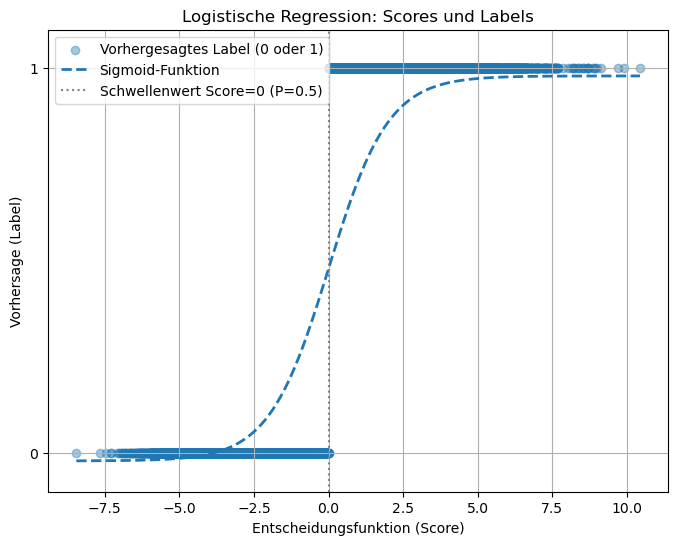

In [28]:
import matplotlib.pyplot as plt

# Berechne die Entscheidungsscores (logits) für die Validierungsdaten
dec_scores  = pipeline.decision_function(X_val)   # Rohwerte vor der Schwellenwertanwendung
# Berechne die vorhergesagten Klassenlabels (0 oder 1) für die Validierungsdaten
pred_labels = pipeline.predict(X_val)

plt.figure(figsize=(8, 6))

# Streudiagramm: Entscheidungsscores gegenüber den vorhergesagten Labels
plt.scatter(dec_scores, pred_labels, alpha=0.4, label='Vorhergesagtes Label (0 oder 1)')

# Erzeuge x-Werte für die ideale Sigmoid-Kurve
x = np.linspace(dec_scores.min(), dec_scores.max(), 300)
# Berechne die Sigmoid-Funktion (Wahrscheinlichkeitsfunktion)
sigmoid = 1 / (1 + np.exp(-x))
# Zeichne die Sigmoid-Kurve, leicht nach unten verschoben, damit sie nicht genau auf den Punkten liegt
plt.plot(x, sigmoid - 0.02, linestyle='--', linewidth=2, label='Sigmoid-Funktion')

# Zeichne eine vertikale Linie bei Score=0, entspricht Schwellenwert für P=0.5
plt.axvline(0, color='gray', linestyle=':', label='Schwellenwert Score=0 (P=0.5)')

# Y-Achse nur 0 und 1 als Labels anzeigen
plt.yticks([0, 1])
plt.ylim(-0.1, 1.1)
plt.xlabel('Entscheidungsfunktion (Score)')
plt.ylabel('Vorhersage (Label)')
plt.title('Logistische Regression: Scores und Labels')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [29]:
from sklearn.experimental import enable_halving_search_cv  # nötig, um HalvingRandomSearchCV zu aktivieren
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold
from scipy.stats import uniform, randint

# Definiere Parameterbereiche für Hypertuning (nur relevant für Pipeline-Schritte 'tfidf' und 'clf')
param_distributions = [
    {
        'tfidf__max_features': randint(5000, 40001),           # Anzahl der Features (5k bis 40k)
        'tfidf__ngram_range': [(1,1), (1,2)],                  # Uni- und/oder Bigrams
        'tfidf__stop_words': [None, 'english'],                # Stoppwörter ein/aus
        'clf__penalty': ['l2', 'l1'],                          # Regularisierungstyp
        'clf__C': uniform(0.01, 10),                           # Inverse Regularisierungsstärke
        'clf__class_weight': [None, 'balanced'],               # Klassen-Gewichtung
        'clf__solver': ['saga'],                                # Solver, saga unterstützt l1 + elasticnet
        'clf__max_iter': [1000],                               # Maximale Iterationen
        'clf__l1_ratio': [None],                                # nur für elasticnet, hier None
    },
    {
        'tfidf__max_features': randint(5000, 40001),
        'tfidf__ngram_range': [(1,1), (1,2)],
        'tfidf__stop_words': [None, 'english'],
        'clf__penalty': ['elasticnet'],
        'clf__C': uniform(0.01, 10),
        'clf__class_weight': [None, 'balanced'],
        'clf__solver': ['saga'],
        'clf__max_iter': [1000],
        'clf__l1_ratio': uniform(0, 1),                         # Nur für elasticnet wichtig
    }
]

# Cross-Validation Setup mit Stratified K-Folds für Klassenbalance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# HalvingRandomSearchCV initialisieren und ausführen (nutzt adaptive Ressourcenzuteilung)
halving_search = HalvingRandomSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    factor=4,                      # Ressourcenfaktor pro Iteration
    resource='n_samples',          # Nutzt Trainingsdatensatzgröße als Ressource
    max_resources=len(X_train),
    min_resources=len(X_train)//5,  # Minimale Ressourcen pro Kandidat
    scoring='accuracy',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    return_train_score=True,
    error_score='raise'
)

# Hypertuning starten (kann eine Weile dauern)
halving_search.fit(X_train, y_train)

# Beste Parameter und Accuracy ausgeben
print("Beste Parameter gefunden:", halving_search.best_params_)
print(f"Beste CV-Accuracy: {halving_search.best_score_:.4f}")

# Bestes Modell auf Validierungsdaten auswerten
best_model = halving_search.best_estimator_
val_preds = best_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds, target_names=['Real', 'Fake']))

# Endgültige Testauswertung mit bestem Modell
test_preds = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print(classification_report(y_test, test_preds, target_names=['Real', 'Fake']))


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 10098
max_resources_: 50493
aggressive_elimination: False
factor: 4
----------
iter: 0
n_candidates: 5
n_resources: 10098
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 1
n_candidates: 2
n_resources: 40392
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Beste Parameter gefunden: {'clf__C': 5.257746602583891, 'clf__class_weight': None, 'clf__l1_ratio': None, 'clf__max_iter': 1000, 'clf__penalty': 'l1', 'clf__solver': 'saga', 'tfidf__max_features': 23431, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
Beste CV-Accuracy: 0.9752
Validation Accuracy: 0.9796672828096118
              precision    recall  f1-score   support

        Real       0.98      0.98      0.98      5254
        Fake       0.98      0.98      0.98      5566

    accuracy                           0.98     10820
   macro avg       0.98      0.98      0.98     10820
weighted avg      

___
# Random Forest
___

![Alt-Text](./Bilder/random-forest.jpg)

<small> Anas Brital | Random Forest algorithm explained . (o. D.): [online] https://anasbrital98.github.io/blog/2021/Random-Forest/ [abgerufen am 09.06.2025]. </small>

- **Anwendung auf nominalskalierte Kriterien, Mehrere Prädiktoren und Angabe einer Wahrscheinlichkeit wie bei Logistic Regression**

- **Zusammenstellung aus vielen Entscheidungsbäumen**  
  - Jeder Baum $h_t$ trifft eine Ja/Nein-Entscheidung („Real“ vs. „Fake“) basierend auf Schwellwerten der TF-IDF-Merkmale  
  - Die Bäume werden auf zufälligen Teilmengen von Daten und Features trainiert


#### Formel: Vorhersagewahrscheinlichkeit im Random Forest

$$
P(Y = 1 \mid \mathbf{x})
= \frac{1}{T} \sum_{t=1}^{T} h_t(\mathbf{x})
$$

- $\mathbf{x} = (x_1, x_2, \dots, x_n)$  
  Merkmalsvektor eines Artikels, erstellt mit `TfidfVectorizer`.

- $T$ = Anzahl der Entscheidungsbäume im Wald  
- $h_t(\mathbf{x}) \in \{0,1\}$ = Vorhersage des $t$-ten Baums (0 = Real, 1 = Fake)


#### Ziel:
Schätzung der Wahrscheinlichkeit, dass ein Artikel Fake News ist – basierend auf dem Votum vieler Entscheidungsbäume.


___
# Random Forest Regression angewandt auf Welfake
___

In [37]:
import pandas as pd  # Importiert die Pandas-Bibliothek zur Datenverarbeitung und -analyse
import numpy as np  # Importiert NumPy für numerische Operationen, z. B. mit Arrays

# Aufteilen der Daten in Trainings-,Validierungs-, und Testdatensätze
from sklearn.model_selection import train_test_split

# Umwandlung von Textdaten in numerische Merkmale mithilfe von TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Klassifizierer (Randomforest) und Evaluationsmetriken
from sklearn.ensemble import RandomForestClassifier  # Random-Forest-Algorithmus zur Klassifikation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Metriken zur Bewertung der Modellleistung

# Werkzeuge zur Erstellung von Pipelines (Verkettung von Verarbeitungsschritten)
from sklearn.pipeline import Pipeline

In [38]:
csv_path = "../src/data/Saurabh Shahane/WELFake_Dataset.csv"  
# Pfad zur CSV-Datei, die den WELFake-Datensatz enthält

# Einlesen der CSV-Datei als DataFrame; Trennzeichen ist ein Komma
df = pd.read_csv(csv_path, sep=',')

# Erster Split: Aufteilen in Trainingsdaten (70 %) und temporäre Daten (30 %), wobei die Klassenverteilung beibehalten wird (stratify)
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])

# Zweiter Split: Aufteilen der temporären Daten in Validierungs- (15 %) und Testdaten (15 %), ebenfalls mit erhaltener Klassenverteilung
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label'])


In [39]:
# Funktion zum Zusammenführen von Titel und Text in ein gemeinsames Texteingabefeld
def merge_text(row):
    return f"{row['title']} \n{row['text']}"

# Wendet die merge_text-Funktion auf jede Zeile der Trainings-, Validierungs- und Testdaten an
# Das Ergebnis wird in einer neuen Spalte 'input_text' gespeichert
for df in [df_train, df_val, df_test]:
    df['input_text'] = df.apply(merge_text, axis=1)

# Definition der Eingabedaten (X) und Zielwerte (y) für das Training, die Validierung und den Test
X_train, y_train = df_train['input_text'], df_train['label']
X_val,   y_val   = df_val['input_text'],   df_val['label']
X_test,  y_test  = df_test['input_text'],  df_test['label']  # y_test wird nur zur finalen Auswertung verwendet


In [40]:
# Initialisieren des TF-IDF-Vektorisierers zur Umwandlung von Text in numerische Merkmale
vectorizer = TfidfVectorizer(
    max_features=40_000,     # Behalte nur die 40.000 häufigsten Begriffe, um die Dimensionalität zu begrenzen
    ngram_range=(1, 2),      # Berücksichtige sowohl einzelne Wörter (Unigramme) als auch Wortpaare (Bigramme)
    stop_words='english',    # Entferne häufige englische Stoppwörter (z. B. "the", "and", "is")
    lowercase=False          # Behalte Groß- und Kleinschreibung bei (kein automatisches Umwandeln in Kleinbuchstaben)
)

# Passe den Vektorisierer auf die Trainingsdaten an und transformiere diese in Sparse-Matrizen (TF-IDF-Werte)
# fit_transform lernt den Wortschatz von X_train und wendet ihn gleichzeitig darauf an
X_train_tfidf = vectorizer.fit_transform(X_train)

# Wende denselben (bereits angelernten) Vektorisierer auf die Validierungs- und Testdaten an
# transform nutzt den zuvor gelernten Wortschatz, um neue Texte in numerische Vektoren umzuwandeln
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)


In [41]:
# Erstellen einer Pipeline, die zuerst den Text in TF-IDF-Vektoren umwandelt und dann einen Random Forest zur Klassifikation nutzt
pipeline = Pipeline([
    ('tfidf', vectorizer),  # Schritt 1: Umwandlung des Rohtexts in TF-IDF-Merkmale
    ('clf', RandomForestClassifier(
        n_estimators=100,    # Anzahl der Bäume im Random-Forest-Klassifikator
        max_depth=None,      # Keine Begrenzung der maximalen Tiefe – Bäume wachsen so lange, bis alle Blätter rein sind
        random_state=42      # Zufallsstartwert für reproduzierbare Ergebnisse
    ))
])

# Trainiere die Pipeline (TF-IDF + Random Forest) auf den Trainingsdaten
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_features=40000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

In [42]:
# Erzeuge Vorhersagen für die Testdaten mit der zuvor trainierten Pipeline
# `test_preds` ist ein Array mit den vorhergesagten Klassenlabels: 0 = Fake, 1 = Real
test_preds = pipeline.predict(X_test)

# Falls die echten Labels der Testdaten (`y_test`) vorliegen, wird die Modellleistung ausgewertet:

# Gib die Genauigkeit (Accuracy) aus – zeigt den Anteil der korrekt klassifizierten Beispiele
print("Test Accuracy:", accuracy_score(y_test, test_preds))

# Gib einen detaillierten Klassifikationsbericht aus (mit Precision, Recall und F1-Score für jede Klasse)
print(classification_report(
    y_test,             # Wahre Klassenlabels (Ground Truth)
    test_preds,         # Vom Modell vorhergesagte Labels
    target_names=['Fake', 'Real']  # Bezeichner für die Klassen (0 = Fake, 1 = Real)
))


Test Accuracy: 0.965345162184641
              precision    recall  f1-score   support

        Fake       0.98      0.95      0.96      5255
        Real       0.95      0.98      0.97      5566

    accuracy                           0.97     10821
   macro avg       0.97      0.96      0.97     10821
weighted avg       0.97      0.97      0.97     10821



In [43]:
from sklearn.experimental import enable_halving_search_cv  # notwendig, um HalvingRandomSearchCV zu verwenden
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold
from scipy.stats import uniform, randint

In [ ]:
# Suchraum für Hyperparameter definieren
param_distributions = {
    'tfidf__max_features': randint(5000, 20001),              # Anzahl der Merkmale (Begriffe)
    'tfidf__ngram_range': [(1, 1), (1, 2)],                   # Nur Unigramme oder auch Bigramme
    'tfidf__min_df': randint(1, 6),                           # Minimale Dokumenthäufigkeit
    'tfidf__max_df': uniform(0.8, 0.2),                       # Maximale Dokumenthäufigkeit (zwischen 0.8 und 1.0)
    'tfidf__stop_words': [None, 'english'],                  # Optional Stopwörter entfernen

    'clf__n_estimators': randint(100, 501),                   # Anzahl der Bäume
    'clf__max_depth': [None] + list(randint(5, 26).rvs(5)),   # Maximale Tiefe der Bäume
    'clf__min_samples_split': randint(2, 11),                # Mindestanzahl an Samples, um einen Split durchzuführen
    'clf__min_samples_leaf': randint(1, 11),                 # Mindestanzahl an Samples pro Blatt
    'clf__max_features': [None, 'sqrt', 'log2']              # Anzahl der Merkmale, die beim Split betrachtet werden
}

# Stratified K-Fold Cross-Validation verwenden, um Klassenverteilung zu erhalten
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Anzahl der Startkandidaten für die erste Runde (Pilotphase)
n_pilot = 2
pilot_frac = 0.3
scale = 1 / pilot_frac
n_full = int(100 * n_pilot / scale)
print(f"Initial candidates for RF halving: {n_full}")

# Halving-Randomized-Search vorbereiten
halving_search = HalvingRandomSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_candidates=n_full,
    factor=3,
    resource='n_samples',
    max_resources=len(X_train),
    min_resources=len(X_train) // 300,
    scoring='accuracy',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    return_train_score=True,
    error_score='raise'
)

# Hyperparameter-Suche auf Trainingsdaten ausführen
halving_search.fit(X_train, y_train)

# Beste Parameter und Leistung ausgeben
print("Beste Parameter für Random Forest:")
print(halving_search.best_params_)
print(f"Beste Cross-Validation-Genauigkeit: {halving_search.best_score_:.4f}")

# Bestes Modell extrahieren und auf Validierungs- und Testdaten evaluieren
best_rf = halving_search.best_estimator_

# Validierungsergebnisse
val_preds = best_rf.predict(X_val)
print("Validierungsgenauigkeit:", accuracy_score(y_val, val_preds))
print("Klassifikationsbericht (Validierung):")
print(classification_report(y_val, val_preds, target_names=['Real', 'Fake']))
print("Konfusionsmatrix (Validierung):")
print(confusion_matrix(y_val, val_preds))

# Testergebnisse
test_preds = best_rf.predict(X_test)
print("Testgenauigkeit:", accuracy_score(y_test, test_preds))
print("Klassifikationsbericht (Test):")
print(classification_report(y_test, test_preds, target_names=['Real', 'Fake']))
print("Konfusionsmatrix (Test):")
print(confusion_matrix(y_test, test_preds))

Initial candidates for RF halving: 60
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 6
min_resources_: 168
max_resources_: 50493
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 168
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 1
n_candidates: 20
n_resources: 504
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 2
n_candidates: 7
n_resources: 1512
Fitting 5 folds for each of 7 candidates, totalling 35 fits
